## 多层感知机

In [19]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))

X = torch.rand(2,20)
net(X)

tensor([[ 0.0564,  0.3624, -0.2350, -0.1679, -0.1006,  0.1623,  0.1666, -0.0841,
          0.2777, -0.2282],
        [ 0.1388,  0.3262, -0.2209, -0.1086,  0.0419,  0.2177,  0.1464,  0.0087,
          0.3764, -0.0959]], grad_fn=<AddmmBackward0>)

多层感知机自己实现

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20,256)
        self.out = nn.Linear(256,10)
    
    def forward(self,X):
        return self.out(F.relu(self.hidden(X)))

In [21]:
net = MLP()
net(X)

tensor([[ 0.0890,  0.0463, -0.1599, -0.0522, -0.0762,  0.2852, -0.2299, -0.2200,
         -0.0646, -0.0457],
        [ 0.0739, -0.0284, -0.0985, -0.0635, -0.0030,  0.3078, -0.2228, -0.0801,
         -0.0412, -0.0737]], grad_fn=<AddmmBackward0>)

## Demo-天气预测

In [22]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [23]:
# 查看数据集
features = pd.read_csv("./data/weather.csv")
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


temp_2：前天的最高温度值<br>
temp_1：昨天的最高温度值<br>
average：在历史中，每年这一天的平均最高温度值<br>
actual：标签值，当天的真实最高温度<br>
friend：朋友预测的可能值

In [24]:
features.shape

(348, 9)

In [25]:
# 将时间转换为时间序列
import datetime

# 分别得到年、月、日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

In [26]:
# 将week转为独热编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [27]:
# 分离y_train
labels = np.array(features['actual'])

# 在特征中去掉y_train
features = features.drop('actual',axis = 1)

# 名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

In [28]:
features.shape

(348, 14)

In [29]:
#有些数值大有些数值小，做标准化
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

StandardScaler<br>
z = (x - u) / s<br>
每个属性/每列来说所有数据都聚集在0附近，标准差为1，使得新的X数据集方差为1，均值为0

### 搭建网络模型

In [30]:
# 将array转为张量
x = torch.tensor(input_features,dtype = float)
y = torch.tensor(labels,dtype = float)

我们打算搭建具有一个隐藏层的多层感知机，为此，我们设定两个线性模型及参数，并且随机初始化它们。<br>
观察训练集的特征为14，所以输入层的w必须是(14,m)，其中m我随意指定为128，意为将14个输入特征转化为隐藏层的128个隐藏特征。由矩阵相乘知识可以得出的是348×128的矩阵，所以我们的biases指定为(128×1)。隐藏层同理。

In [31]:
# 权重参数初始化
weights = torch.randn((14,128),dtype = float,requires_grad = True)
biases = torch.randn(128,dtype = float,requires_grad = True)
weights2 = torch.randn((128,1),dtype = float,requires_grad = True)
biases2 = torch.randn(1,dtype = float,requires_grad = True)

In [32]:
# 学习率
learning_rate = 0.01
losses = []

In [37]:
# 梯度下降
for i in range(1000):
    # 计算隐藏层-线性模型
    hidden = x.mm(weights) + biases
    # 加入激活函数-加入激活函数
    hidden = torch.relu(hidden)
    # 预测结果计算
    predictions = hidden.mm(weights2) + biases2    
    # 计算损失
    loss = torch.mean((predictions - y) ** 2)
    # 记录损失
    losses.append(loss.data.numpy())
    
    if i%100 == 0:
        print('loss---',loss)

    # 反向传播
    loss.backward()


    print(weights.grad.data)
    # 更新参数
    weights.data.add_(-learning_rate * weights.grad.data)
    biases.data.add_(-learning_rate * biases.grad.data)
    weights2.data.add_(-learning_rate * weights2.grad.data)
    biases2.data.add_(-learning_rate * biases2.grad.data)
    
    # 每次迭代前清空梯度
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss--- tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
t

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, na

## 使用API实现

In [48]:
# 指定规模
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

# 搭建网络
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size,hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size),
)

# 定义损失函数
cost = torch.nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(my_nn.parameters(),lr = 0.001)

In [49]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # 小批量随机梯度下降进行训练
    for start in range(0,len(input_features),batch_size):
        end = start+batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],dtype = torch.float,requires_grad = True)
        yy = torch.tensor(labels[start:end],dtype = torch.float,requires_grad = True)
        prediction = my_nn(xx)
        loss = cost(prediction,yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    # 打印损失
    # 打印损失值
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))

D:\Users\QianWu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Users\QianWu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 3930.1135
100 37.743317
200 35.646347
300 35.30317
400 35.13176
500 34.995995
600 34.874374
700 34.755116
800 34.635433
900 34.514103


### 评估模型

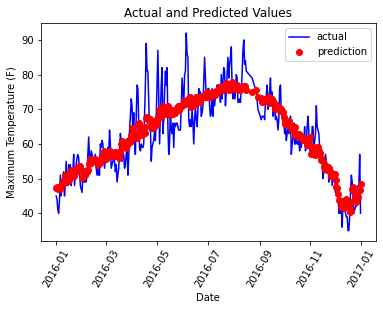

In [50]:
x = torch.tensor(input_features,dtype = torch.float)
predict = my_nn(x).data.numpy()

# 转换日期格式
dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date':dates,'actual':labels})

# 同理，在创建一个来存日期和其对应的模型预测值
mouths = features[:,feature_list.index('month')]
days = features[:,feature_list.index('day')]
years = features[:,feature_list.index('year')]

test_dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
test_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date':test_dates,'prediction':predict.reshape(-1)})

# 真实值
plt.plot(true_data['date'],true_data['actual'],'b-',label = 'actual')

# 预测值
plt.plot(predictions_data['date'],predictions_data['prediction'],'ro',label = 'prediction')
plt.xticks(rotation = '60')
plt.legend()

# 图名
plt.xlabel('Date');plt.ylabel('Maximum Temperature (F)');plt.title('Actual and Predicted Values')

plt.show()